# H12

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import backend as K 
from keras.datasets import cifar10

K.set_image_dim_ordering('tf')

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold 
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from astropy.table import Table

import glob
import h5py    

from PIL import Image
from scipy.misc import toimage
from scipy import signal
import skimage
from skimage import data, io
from skimage.transform import rescale, resize, downscale_local_mean

from matplotlib import pyplot
import matplotlib.pylab as plt 
from IPython.display import Image
%matplotlib inline

# if you do not have skimage then you may install is by running $ conda install -c anaconda scikit-image

Using TensorFlow backend.


In this homework, we will explore Convolutional Neural Networks (CNNs).  We'll explore the mechanics of convolutional operations, will build a CNN to classify CIFAR-10 images, and will build a CNN for detecting gravitational waves from the LIGO observatory. Specifically, we will use images generated from the raw time series data to train a model that can distinguish between real gravitational events and noise. 

## Convolutional Neural Network Basics


As you know from lecture, in convolutional neural networks, a convolution is a multiplicative operation on a local region of values. Convolutional layers have shown themselves to have been very useful in image classification, as they allows the network to retain local spatial information for feature extraction.

<span class='sub-q'>**1.1 Calculate Convolutions.**</span>

For the following 2D matrix:

$$
\left( \begin{array}{cccc}
2 & 3 & 2 & 4 \\
3 & 1 & 2 & 2 \\
4 & 1 & 0 & 1 \\
7 & 2 & 1 & 3
\end{array} \right)
$$

you will use the following 2x2 kernel to perform a 2D convolution operation.

$$
\left( \begin{array}{cc}
2 & 1 \\
1 & 3 
\end{array} \right)
$$

Compute this operation by hand assuming a vertical and horizontal stride of 1 as well as a) valid, b) same, and c) full border modes.  For each mode, indicate the shape of the the resulting (post-convolution) matrix and compare it to the shape of the original matrix.

**a) valid**

In [3]:
print("\n",
     2*2+3*1+3*1+1*3,3*2+2*1+1*1+2*3,2*2+4*1+2*1+2*3,"\n",\
     3*2+1*1+4*1+1*3,1*2+2*1+1*1+0*3,2*2+2*1+0*1+1*3,"\n",\
     4*2+1*1+7*1+2*3,1*2+0*1+2*1+1*3,0*2+1*1+1*1+3*3)



 13 15 16 
 14 5 9 
 22 7 11


$$
\left( \begin{array}{cccc}
13 & 15 & 16\\
14 & 5 & 9 \\
22 & 7 & 11 \\
\end{array} \right)
$$

The shape of the resulting matrix is 3 by 3 which is smaller than the original one 4 by 4


**b) same**

$$
\left( \begin{array}{cccc}
0 &0 & 0 & 0 & 0 \\
0 & 2 & 3 & 2 & 4 \\
0 & 3 & 1 & 2 & 2 \\
0 & 4 & 1 & 0 & 1 \\
0 & 7 & 2 & 1 & 3 \\
\end{array} \right)
$$

$$
\left( \begin{array}{cc}
2 & 1 \\
1 & 3 
\end{array} \right)
$$

In [4]:
print(
    "\n",
     0*2+0*1+0*1+2*3,0*2+0*1+2*1+3*3,0*2+0*1+3*1+2*3,0*2+0*1+2*1+4*3,"\n",\
     0*2+2*1+0*1+3*3,2*2+3*1+3*1+1*3,3*2+2*1+1*1+2*3,2*2+4*1+2*1+2*3,"\n",\
     0*2+3*1+0*1+4*3,3*2+1*1+4*1+1*3,1*2+2*1+1*1+0*3,2*2+2*1+0*1+1*3,"\n",\
     0*2+4*1+0*1+7*3,4*2+1*1+7*1+2*3,1*2+0*1+2*1+1*3,0*2+1*1+1*1+3*3,"\n",\
)


 6 11 9 14 
 11 13 15 16 
 15 14 5 9 
 25 22 7 11 



$$
\left( \begin{array}{cccc}
6 & 11 & 9 & 14 \\
11 & 13 & 15 & 16 \\
15 & 14 & 5 & 9\\
25 & 22 & 7 & 11\\
\end{array} \right)
$$

The shape of the resulting matrix is 4 by 4 which is the same as the original one 4 by 4

**c) full**

$$
\left( \begin{array}{cccc}
0 &0 & 0 & 0 & 0 &0 \\
0 & 2 & 3 & 2 & 4 &0 \\
0 & 3 & 1 & 2 & 2 &0 \\
0 & 4 & 1 & 0 & 1 &0 \\
0 & 7 & 2 & 1 & 3 &0 \\
0 &0 & 0 & 0 & 0 &0 \\
\end{array} \right)
$$

$$
\left( \begin{array}{cc}
2 & 1 \\
1 & 3 
\end{array} \right)
$$

In [5]:
print(
    "\n",
     0*2+0*1+0*1+2*3,0*2+0*1+2*1+3*3,0*2+0*1+3*1+2*3,0*2+0*1+2*1+4*3,0*2+0*1+4*1+0*3,"\n",\
     0*2+2*1+0*1+3*3,2*2+3*1+3*1+1*3,3*2+2*1+1*1+2*3,2*2+4*1+2*1+2*3,4*2+0*1+2*1+0*3,"\n",\
     0*2+3*1+0*1+4*3,3*2+1*1+4*1+1*3,1*2+2*1+1*1+0*3,2*2+2*1+0*1+1*3,2*2+0*1+1*1+0*3,"\n",\
     0*2+4*1+0*1+7*3,4*2+1*1+7*1+2*3,1*2+0*1+2*1+1*3,0*2+1*1+1*1+3*3,1*2+0*1+3*1+0*3,"\n",\
     0*2+7*1+0*1+0*3,7*2+2*1+0*1+0*3,2*2+1*1+0*1+0*3,1*2+3*1+0*1+0*3,3*2+0*1+0*1+0*3
)


 6 11 9 14 4 
 11 13 15 16 10 
 15 14 5 9 5 
 25 22 7 11 5 
 7 16 5 5 6


$$
\left( \begin{array}{cccc}
6 & 11 & 9 & 14 & 4 \\
11 & 13 & 15 & 16 & 10 \\
15 & 14 & 5 & 9 & 5\\
25 & 22 & 7 & 11 & 5\\
7 & 16 & 5 & 5 & 6 \\
\end{array} \right)
$$

The shape of the resulting matrix is 5 by 5 which is bigger than the original one 4 by 4

<span class='sub-q'>**1.2 Understanding Pooling Operations.**</span>

Pooling operations are often used in convolutional neural networks to reduce the dimensionality of the feature maps as well as overall network complexity. Two main types of pooling are used: AveragePooling and MaxPooling.

**1.2.1.** Using the matrix below, write the output of the AveragePooling and MaxPooling operations with pool size 2x2 and stride  2x2.

$$
\left( \begin{array}{cccc}
1 & 2 & 2 & 4 \\
3 & 1 & 2 & 1 \\
4 & 1 & 0 & 2 \\
5 & 2 & 2 & 1
\end{array} \right)
$$


In [6]:
print(np.mean([1,2,3,1]),np.mean([2,4,2,1]) , "\n",
      np.mean([4,1,5,2]),np.mean([0,2,2,1]))

print(np.max([1,2,3,1]),np.max([2,4,2,1]) , "\n",
      np.max([4,1,5,2]),np.max([0,2,2,1]))

1.75 2.25 
 3.0 1.25
3 4 
 5 2


** Average Pooling **
$$
\left( \begin{array}{cc}
1.75 & 2.25 \\
 3.0 & 1.25 \\
\end{array} \right)
$$

** Max Pooling **
$$
\left( \begin{array}{cc}
3 & 4 \\
 5 & 2 \\
\end{array} \right)
$$


**1.2.2.** Repeat 1.2.1 with a stride of size 1.

In [7]:
print(np.mean([1,2,3,1]),np.mean([2,2,1,2]),np.mean([2,4,2,1]) , "\n",
      np.mean([3,1,4,1]),np.mean([1,2,1,0]),np.mean([2,1,0,2]) , "\n",
      np.mean([4,1,5,2]),np.mean([1,0,2,2]),np.mean([0,2,2,1]))

print(np.max([1,2,3,1]),np.max([2,2,1,2]),np.max([2,4,2,1]) , "\n",
      np.max([3,1,4,1]),np.max([1,2,1,0]),np.max([2,1,0,2]) , "\n",
      np.max([4,1,5,2]),np.max([1,0,2,2]),np.max([0,2,2,1]))

1.75 1.75 2.25 
 2.25 1.0 1.25 
 3.0 1.25 1.25
3 2 4 
 4 2 2 
 5 2 2


** Average Pooling **
$$
\left( \begin{array}{cc}
1.75 & 1.75 & 2.25 \\
 2.25 & 1.0 & 1.25 \\
 3.0 & 1.25 & 1.25 \\
\end{array} \right)
$$

** Max Pooling **
$$
\left( \begin{array}{cc}
3 & 2 & 4 \\
 4 & 2 & 2 \\
 5 & 2 & 2 \\
\end{array} \right)
$$

**1.3.1.** Load the image as a 2D Numpy array into the variable `dog_image_data`. Appropriately normalize the image data so that values within `dog_image_data` fall within [-0.5, 0.5].  .


Minimum: -0.50, and Maximum: 0.50


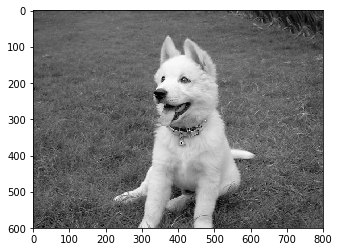

In [8]:
dog_image_data = plt.imread('data/Kintamani_dog_white_gs.jpeg')[:,:,0]
dog_image_data = (dog_image_data-127.5)/255
print("Minimum: %.2f, and Maximum: %.2f" % (np.min(dog_image_data), np.max(dog_image_data)))
plt.imshow(dog_image_data, cmap='gray')
plt.show()

**1.3.2.** Choose three 3x3 convolution kernels (you can look up kernels for edge detection, normalized box blurring, and sharpening, see https://en.wikipedia.org/wiki/Kernel_(image_processing) for example), and apply each of these kernels to the image with same border mode (you may want to implement your own convolution function or try using  [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)).


Edge 
\begin{bmatrix}
-1 &  -1 & -1 \\
-1 & \ \ 8 & -1 \\
-1 &  -1 & -1
\end{bmatrix}


Normalized box blurring
\begin{bmatrix}
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9
\end{bmatrix}


Sharpening
\begin{bmatrix}
\ \ 0 & -1 & \ \ 0 \\
-1 & \ \ 5 & -1 \\
\ \ 0 & -1 & \ \ 0
\end{bmatrix}

In [9]:
edge = np.array([[-1,-1,-1],
                 [-1, 8,-1],
                 [-1,-1,-1]])

blur = np.array([[1/9,1/9,1/9],
                 [1/9,1/9,1/9],
                 [1/9,1/9,1/9]])

sharp = np.array([[ 0,-1,0],
                  [-1, 5,-1],
                  [ 0,-1,0]])

edge_convol = signal.convolve2d(dog_image_data, edge, mode='same')
blur_convol = signal.convolve2d(dog_image_data, blur, mode='same')
sharp_convol = signal.convolve2d(dog_image_data, sharp, mode='same')

**1.3.3.** In the resulting convolved image data matrices, set all pixel values less than zero to zero (using np.clip()). In other words:


`
if x < 0:
    x = 0
else:
    x = x
`

(This is the `ReLU` activation function.)


In [10]:
edge_out = np.clip(edge_convol, a_min=0, a_max=None)
blur_out = np.clip(blur_convol, a_min=0, a_max=None)
sharp_out = np.clip(sharp_convol, a_min=0, a_max=None)

**1.3.4.** Show plots of the resulting images. 

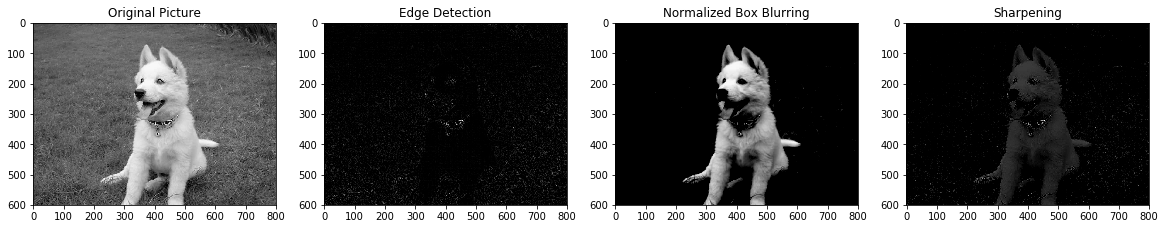

In [11]:
f, ax = plt.subplots(1, 4, figsize=(20,30))

ax[0].imshow(dog_image_data, cmap='gray')
ax[0].set_title('Original Picture')

ax[1].imshow(edge_out, cmap='gray')
ax[1].set_title('Edge Detection')

ax[2].imshow(blur_out, cmap='gray')
ax[2].set_title('Normalized Box Blurring')

ax[3].imshow(sharp_out, cmap='gray')
ax[3].set_title('Sharpening')

plt.show()

**1.3.5.** Take a moment to examine the convolved images. You should see that certain features in the puppy are accentuated, while others are de-emphasized. What might be the effect of performing additional convolution operations on these filtered images and how might they relate to additional layers in a neural network?


Each CNN layer learns filters of increasing complexity. The first layers learn basic feature detection filters: edges, corners, etc. The middle layers learn filters that detect parts of objects. For dogs, they might learn to respond to eyes, noses, etc. The last layers have higher representations: they learn to recognize full objects, in different shapes and positions.

## Building a Basic CNN Model 

In this question, you will use Keras to create a convolutional neural network for predicting the type of object shown in images from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset, which contains 50,000 32x32 training images and 10,000 test images of the same size, with a total of 10 classes.


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

*Some imports that will come in handy if you use keras-vis to implement saliency maps*

In [23]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

<span class='sub-q'> **2.1 Loading CIFAR-1O and Constructing the Model. **</span>

Load CIFAR-10 and use a combination of the [following layers](https://keras.io/layers/convolutional/): Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order) to build your model.
You may use an existing architecture like AlexNet or VGG16, or create one of your own design. However, you should write your own layers and not use a pre-written implementation.

Convolutional neural networks are very computationally intensive. We highly recommend that you train your model on a system using GPUs. On CPUs, this training can take up to several hours. On GPUs, it can be done within minutes.

You can approach the problems in this question by first creating a model assigning 32 filters to each Conv2D layer recreate the model with 64 filters/layer, 128, etc.  For each generated model, keep track of the total number of parameters.

In [12]:
def cnn_model(input_shape, num_classes, n_filter=32):

    model = Sequential()
    model.add(Conv2D(n_filter, (3, 3), padding='same',
                     input_shape=input_shape, activation='relu'))
    model.add(Conv2D(n_filter, (3, 3),activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(n_filter, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(n_filter, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

**2.1.1.** Report the total number of parameters in your model.


In [13]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [14]:
cifar10_model = cnn_model(input_shape=(32,32,3), num_classes=num_classes, n_filter=64)
print("Total parameters for 64 filters is", cifar10_model.count_params())
cifar10_model.summary()

Total parameters for 64 filters is 1297866
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (Non

**2.1.2.** How does the number of total parameters change (linearly, exponentially) as the number of filters per layer increases?


In [15]:
filters_list = []
total_param = []
for x in range(1,10):
    models = cnn_model(input_shape=(32,32,3), num_classes=num_classes, n_filter=32*(2**x))
    total_param.append(models.count_params())
    filters_list.append(32*x)

print(filters_list)
print(total_param)

[32, 64, 96, 128, 160, 192, 224, 256, 288]
[1297866, 2811274, 6501642, 16536586, 47223306, 151064074, 528614922, 1963193866, 7550260746]


The number of total parameter is growing exponentially as the number of filter growing with 32*(2^x)

**2.1.3.** Generate a plot showing the relationship in 2.1.2 and explain what you see.

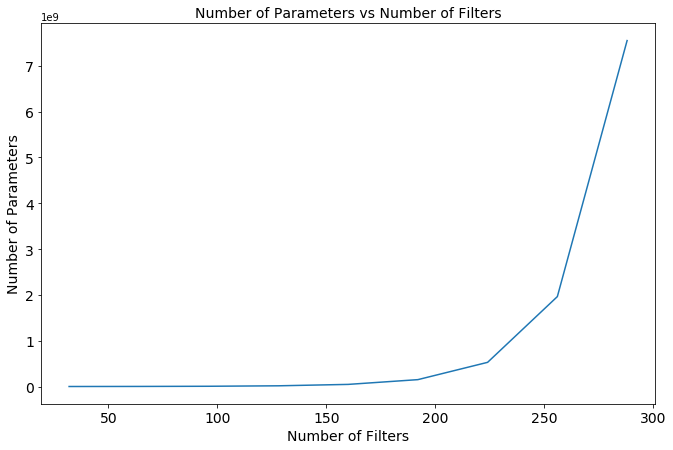

In [16]:
f, ax = plt.subplots(1, 1, figsize=(11,7))

ax.plot(filters_list, total_param)
ax.set_title("Number of Parameters vs Number of Filters", fontsize=14)
ax.set_xlabel("Number of Filters", fontsize=14)
ax.set_ylabel("Number of Parameters", fontsize=14)
ax.tick_params(labelsize=14)
plt.show()

The number of total parameter is growing exponentially as the number of filter growing with 32*(2^x)

<span class='sub-q'> **2.2 Choosing a Model, Training and Evaluating It. **</span>

**2.2.1.** Choose a model from 2.1 and train it. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs.  Your validation accuracy should exceed 70%. Training for 10 epochs on a CPU should take about 30-60 minutes.

In [67]:
K.clear_session()
cifar10_model = cnn_model(input_shape=(32,32,3), num_classes=num_classes, n_filter=64)

cifar10_model.compile(loss='categorical_crossentropy',
                      optimizer='sgd',
                      metrics=['accuracy'])

In [68]:
model_history = cifar10_model.fit(x_train, y_train, epochs=60, batch_size=64, validation_split=.2, verbose=0)
cifar10_model.save('cifar10_model.h5')

# # Read the model
# from keras.models import load_model
# cifar10_model  = load_model('cifar10_model.h5')

In [69]:
print("Training accuracy: %.2f" % model_history.history['acc'][-1])
print("Validation accuracy: %.2f" % model_history.history['val_acc'][-1])
print("Test accuracy: %.2f" % cifar10_model.evaluate(x_test, y_test, verbose=0)[1])

Training accuracy: 0.79
Validation accuracy: 0.78
Test accuracy: 0.77


**2.2.2.** Plot the loss and validation accuracy for your chosen architecture.

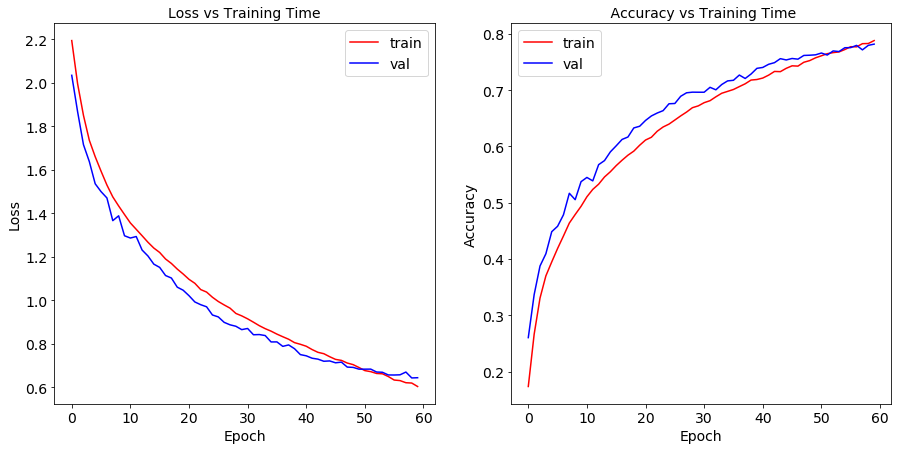

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

ax[0].plot(model_history.history['loss'], 'r', label='train')
ax[0].plot(model_history.history['val_loss'], 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=14)
ax[0].set_ylabel(r'Loss', fontsize=14)
ax[0].set_title(r'Loss vs Training Time', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(model_history.history['acc'], 'r', label='train')
ax[1].plot(model_history.history['val_acc'], 'b' ,label='val')
ax[1].set_xlabel(r'Epoch', fontsize=14)
ax[1].set_ylabel(r'Accuracy', fontsize=14)
ax[1].set_title(r' Accuracy vs Training Time', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(labelsize=14)

**2.3.1.** For a given input image, use your model and extract 9 feature maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid.  Make sure to plot (and clearly label) your original input image as well.

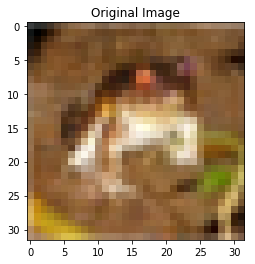

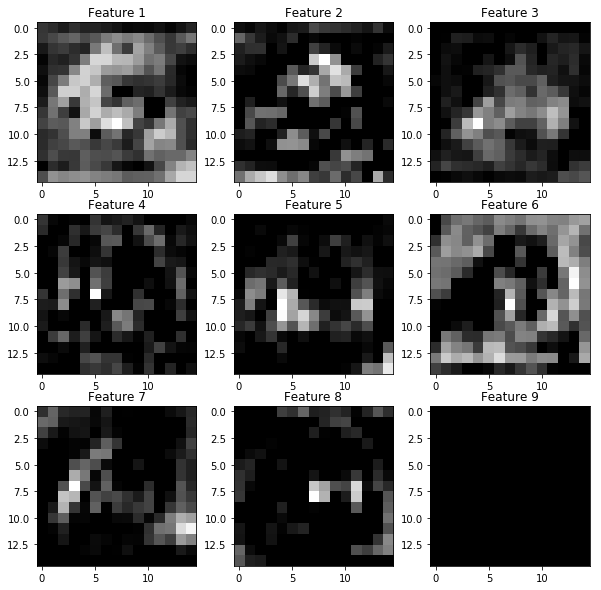

In [71]:
f, ax = plt.subplots(1, 1, figsize=(4,4))
ax.imshow(x_train[0])
ax.set_title("Original Image")

features = get_feature_maps(cifar10_model, 4, x_train[0])[0:10]

f, ax = plt.subplots(3, 3, figsize=(10,10))
axs = ax.ravel()
for i in range(9):
    axs[i].imshow(features[i], cmap='gray')
    axs[i].set_title("Feature %s" % str(i+1))

**2.3.2.** For the same input image generate and plot a saliency map to show the pixels in the image most pertinent to classification.  While you're welcome to generate the saliency map by hand, we highly recommend that you install and use [keras-vis](https://github.com/raghakot/keras-vis) and let it handle the generation.

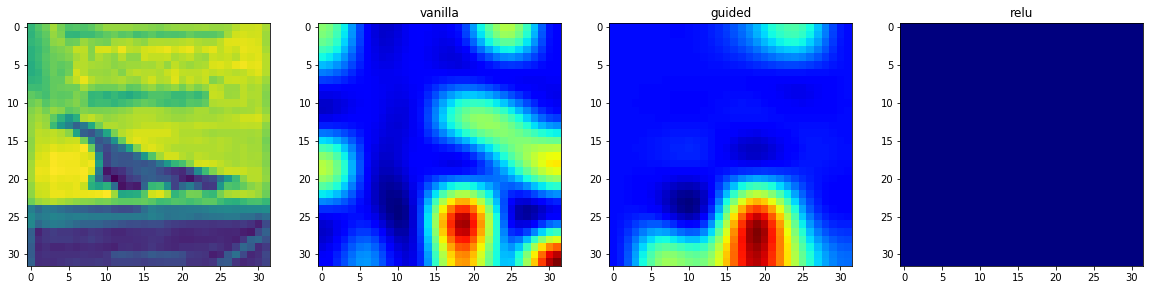

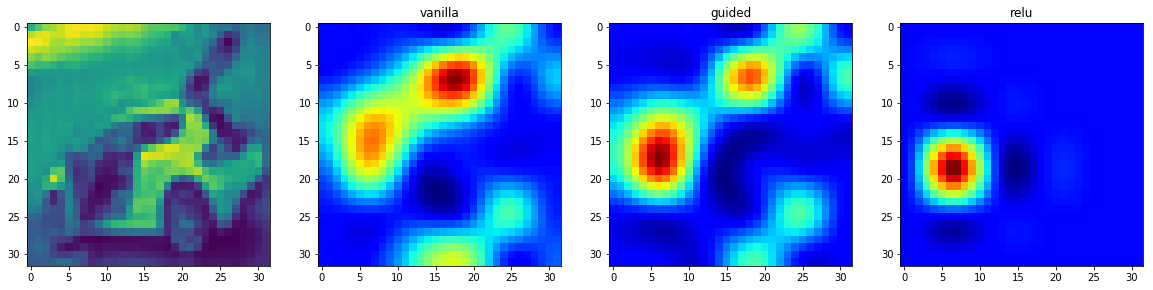

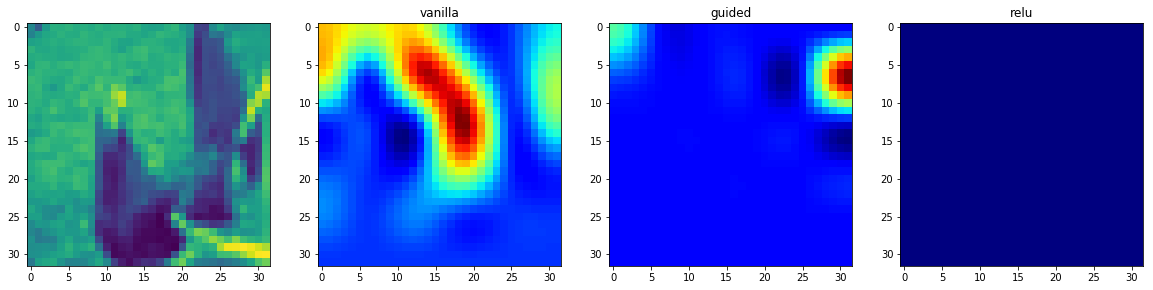

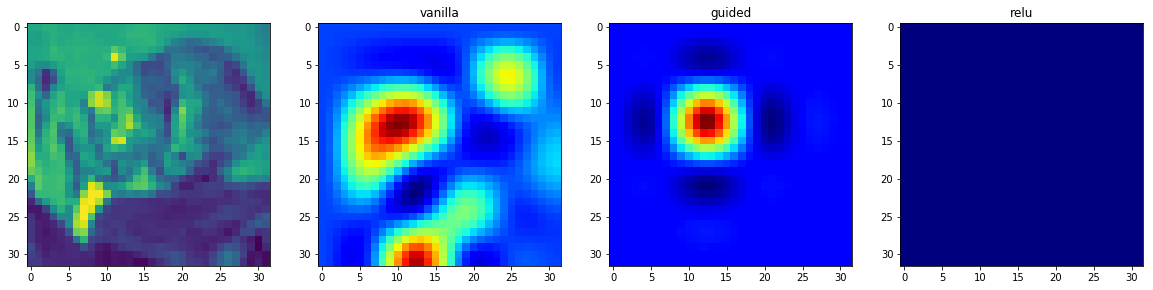

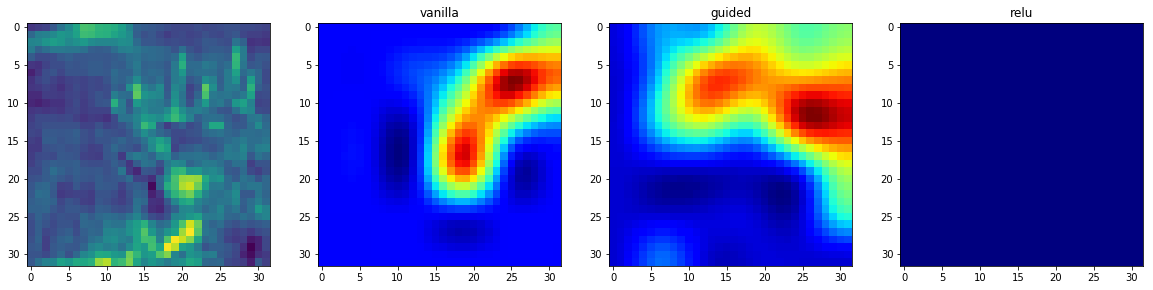

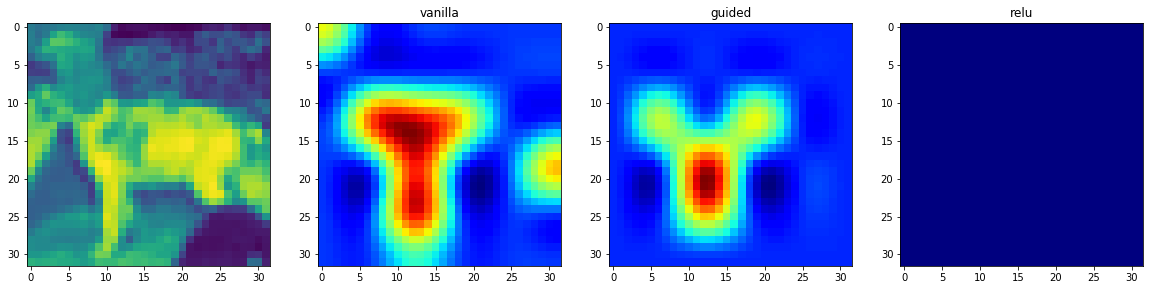

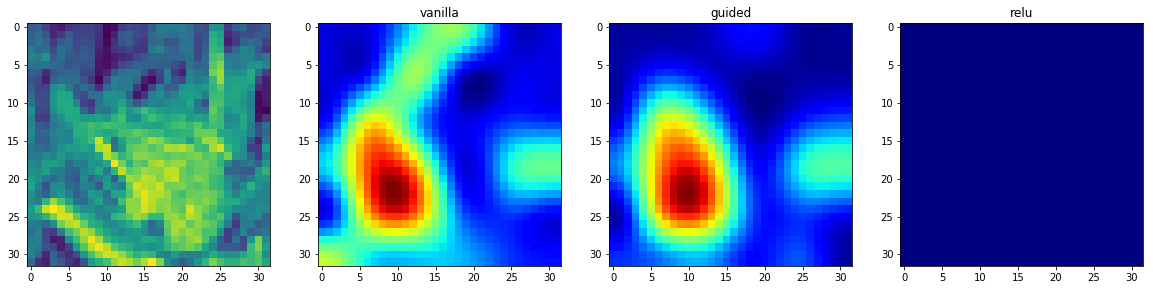

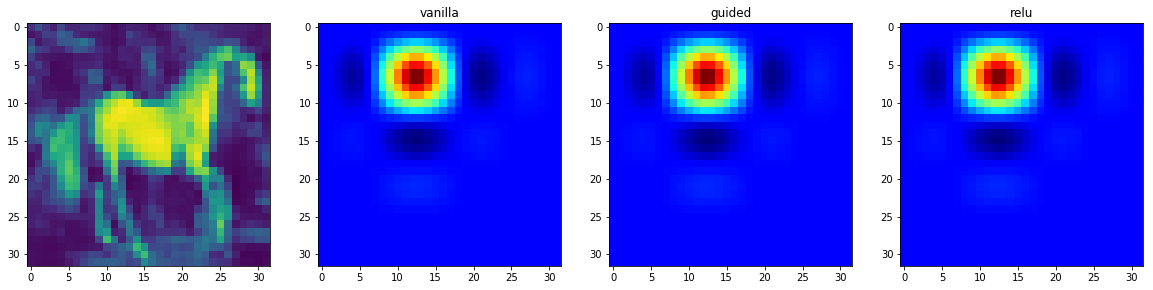

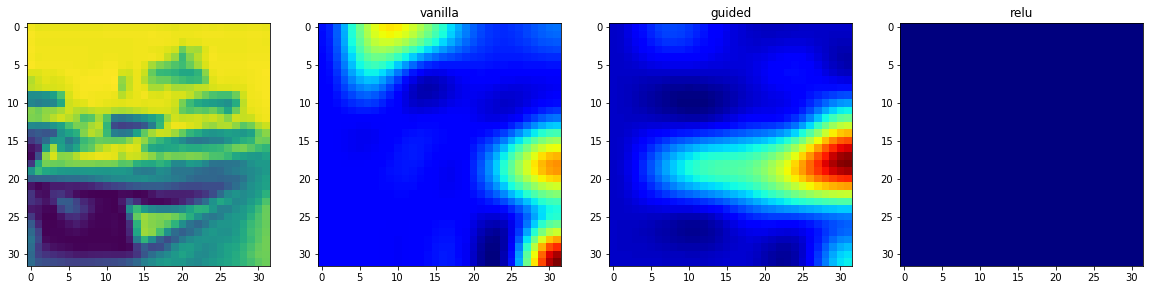

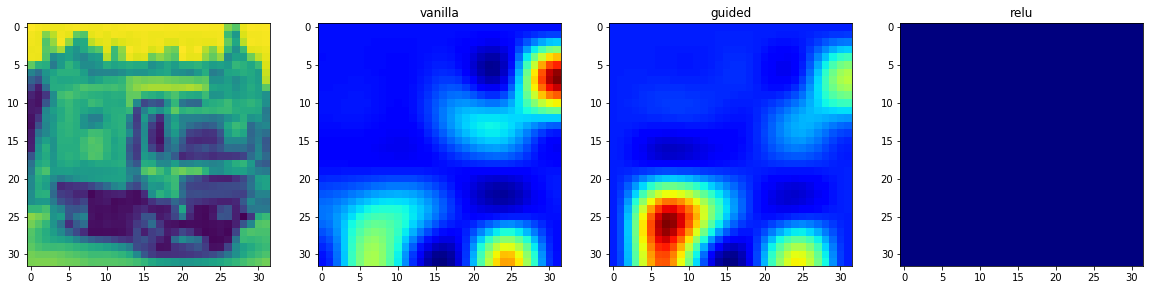

In [78]:
layer_idx = -1
plt.rcParams["figure.figsize"] = (20,20)
from vis.visualization import visualize_cam
import warnings
warnings.filterwarnings('ignore')

# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(cifar10_model, layer_idx, filter_indices=class_idx, 
                              seed_input=x_test[idx], backprop_modifier=modifier)        
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

## Building a CNN for Classification of Gravity Wave Events

Gravitational waves are a prediction of Einstein's Genaral Relativity theory.  They are ripples on the space-time, propagating at the speed of light, caused by the merging of two massive obejcts (e. g. black holes, white dwarves, pulsars) .

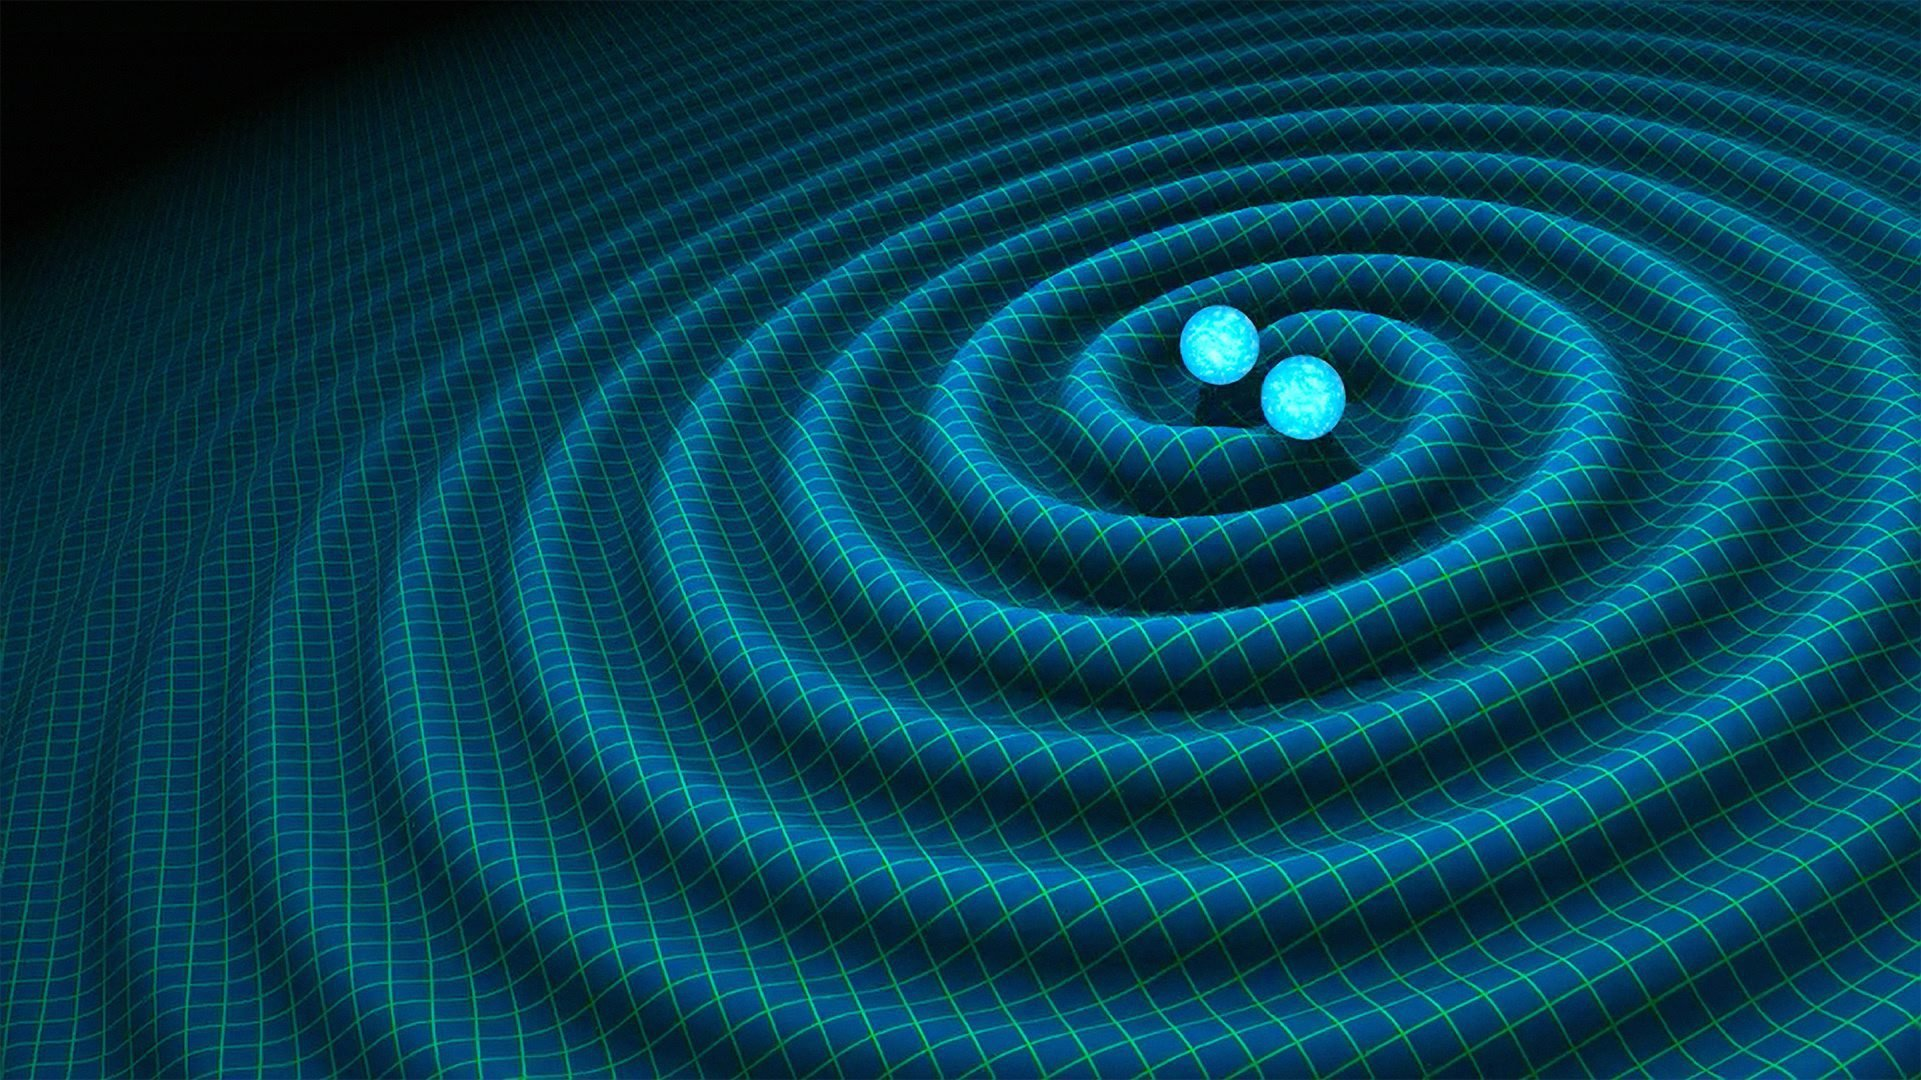

In [25]:
Image('data/gravitational-waves-generated-by-binary-neutron-stars.jpg', width=1000)

### LIGO observatory
The Laser Interferometer Gravitational-Wave Observatory (LIGO) was designed for the direct detection of gravitational waves. It is made up of two identical and widely separated interferometers that look like this: 

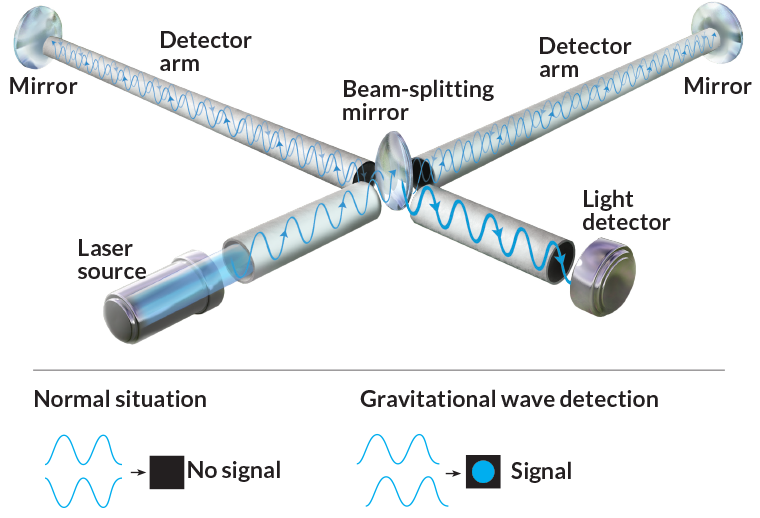

In [26]:
Image('data/100317_nobel-physics_inline_ligo-diagram.png', width=1000)

Image credit: NICOLLE RAGER FULLER

### Nobel Price Physics:
Rainer Weiss, Barry Barish, and Kip Thorne won the 2017 Nobel Prize in Physics for their work on GWs

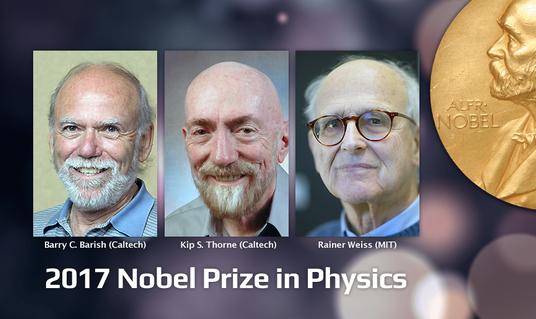

In [27]:
Image('data/Nobel-barish-thorne-weiss_edit.png', width=600)

Image credit: LIGO/Caltech/MIT

### What do Gravitation Wave signals look like?

This is the data from the first GW detection. The first row shows the time series observed, the second the expected signal from simulations, and the third the intensity of each frequency in time from the observed data. The left column corresponds to the Hanford detector in Washington, and the right column to the Livingston detector in Louisiana.  The GW was seen by both detectors, as expected for a real event.

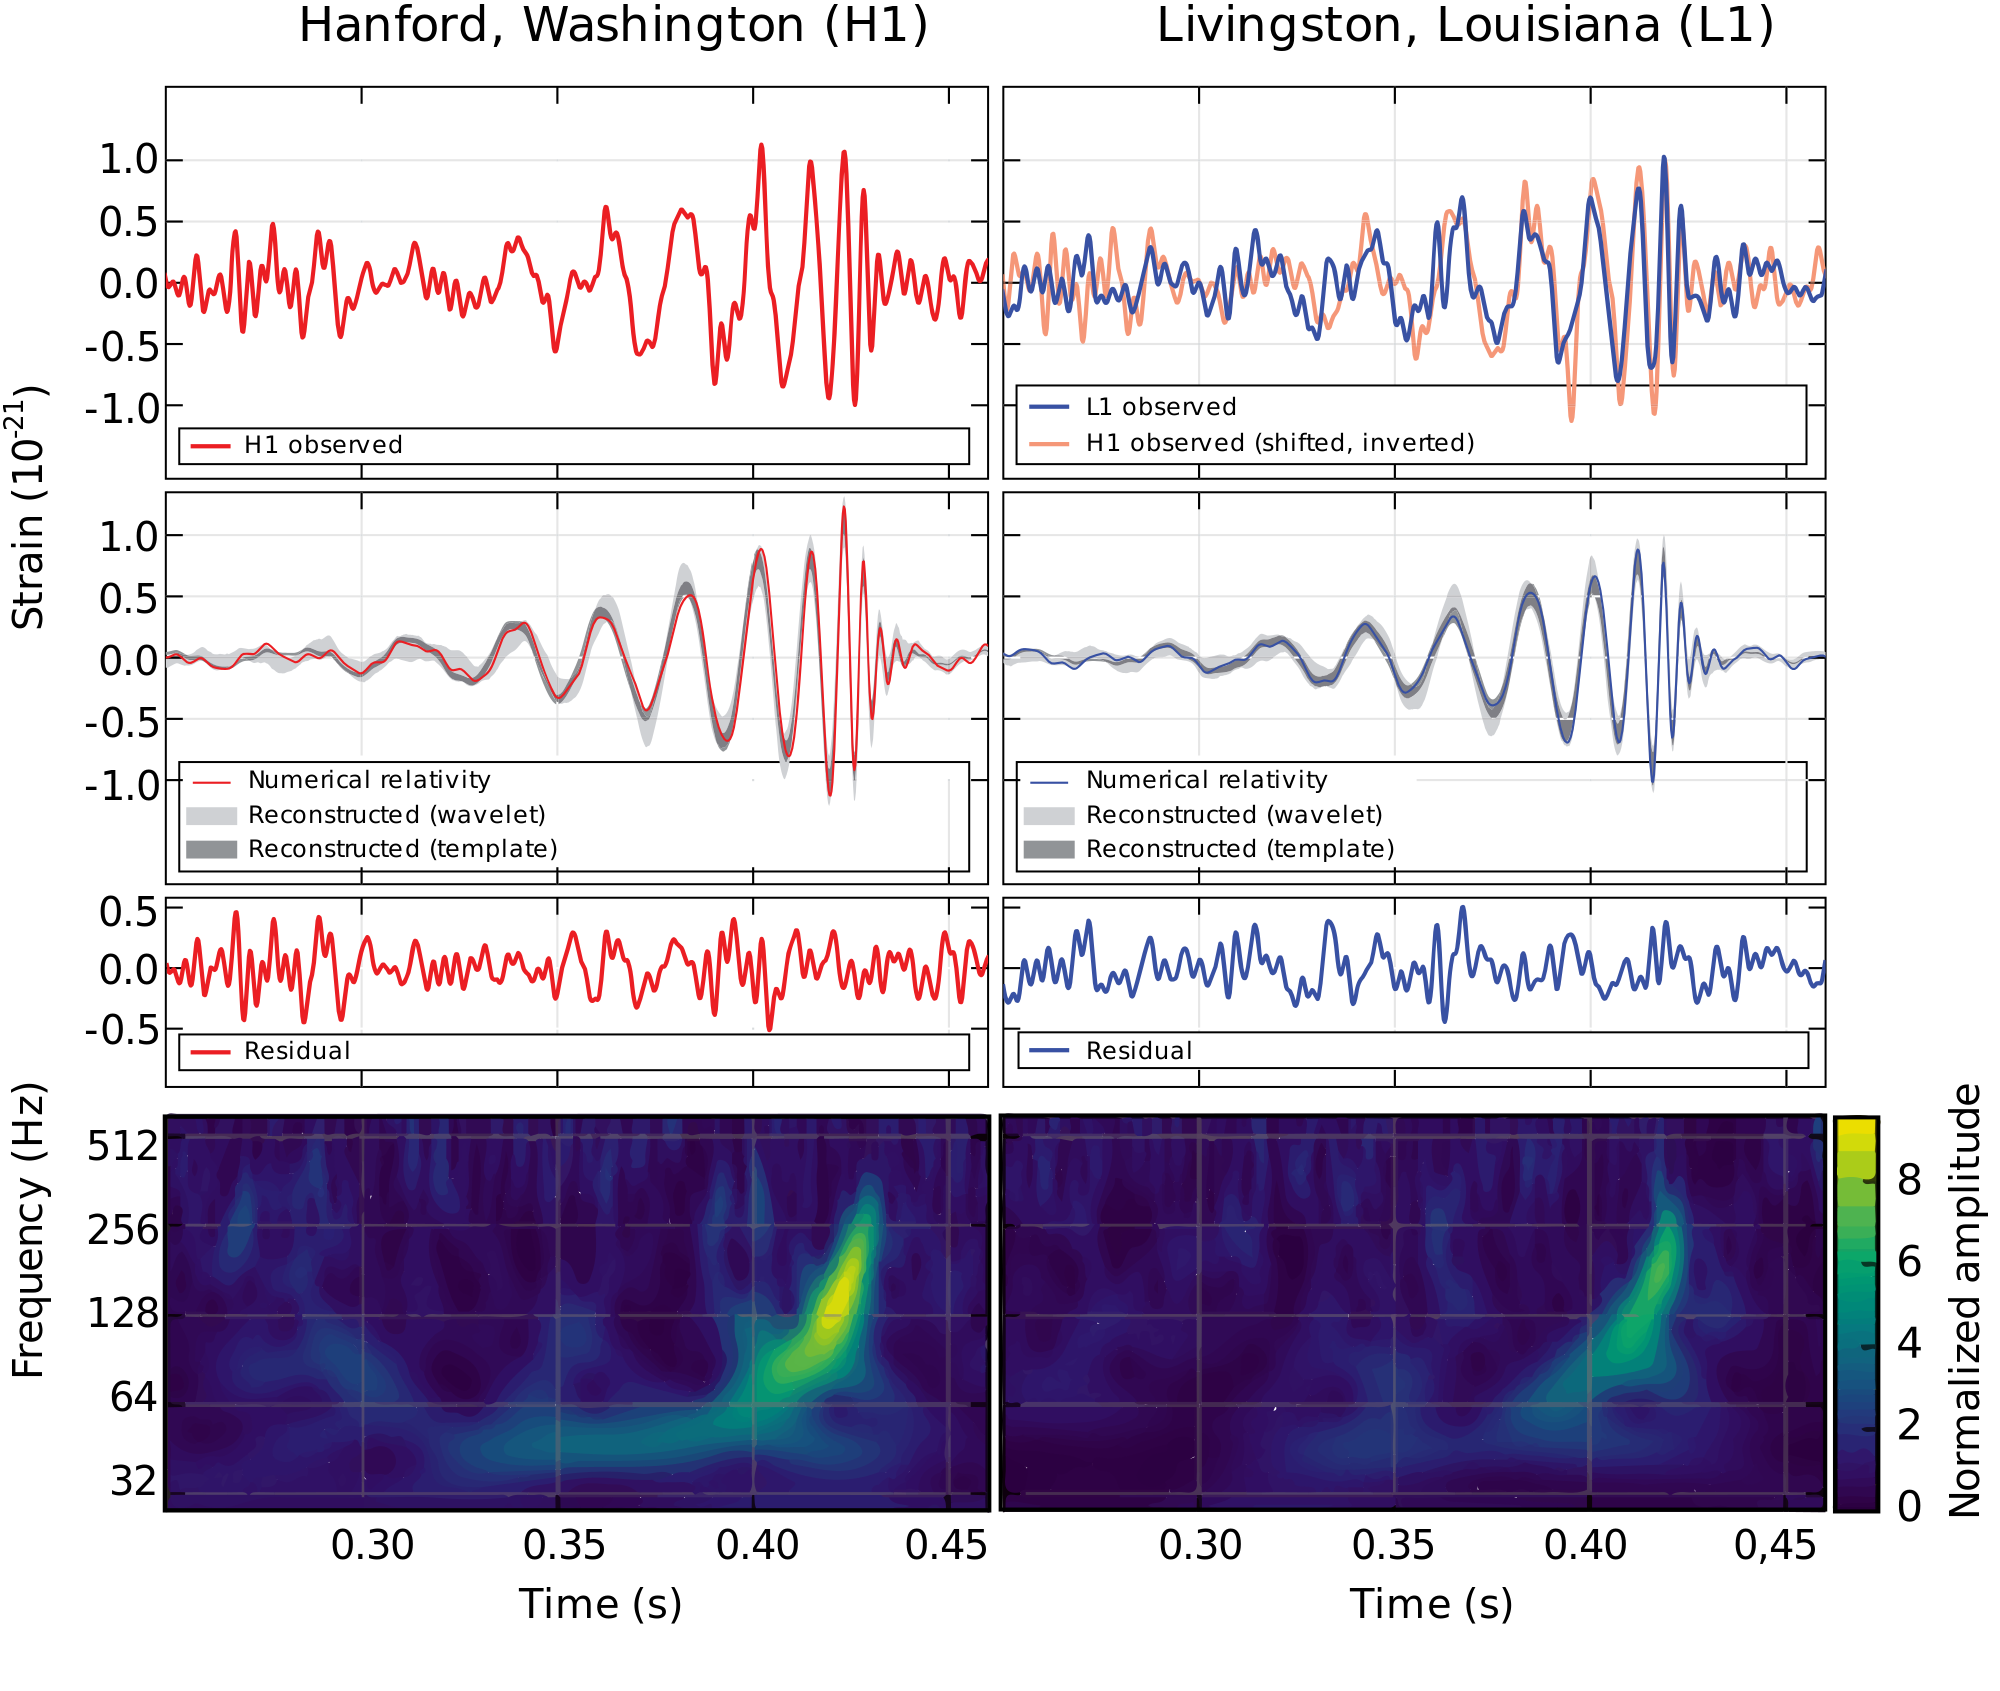

In [28]:
Image('data/LIGO_measurement_of_gravitational_waves.svg.png', width=1100)

Phys. Rev. Lett. 116, 061102 (2016) (https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)


You have built, trained, evaluated and inspected neural networks on a few common datasets such as MNIST or CIFAR10. Now it's time to try a real-world dataset. We want you to consider the problem of classifying images as either gravitational waves or non-detection events using images from two detectors, one from the LIGO Hanford and LIGO Livingston.

 You may find it helpful to gain some domain knowledge on gravitational wave detection. Browse through the information at the following links:

- https://www.ligo.caltech.edu/page/gravitational-waves 
- https://www.zooniverse.org/projects/zooniverse/gravity-spy 

Choose appropriate methods and visualizations to draw conclusions and answer the following questions.

<span class='sub-q'>**3.1 Learn about Gravitational Wave Detection. Load and Clean the Data.**</span>

**3.1.1** Why do you think it is important to have data from both detectors? How might you combine observations from the two detectors into a single observation? 

LIGO was designed with two detectors so far apart for good reason. LIGOâ€™s detectors are so sensitive that they can 'feel' the tiniest vibrations on the Earth from sources very nearby to sources hundreds or thousands of miles away. Things like earthquakes, acoustic noise (e.g., trucks driving on nearby roads, farmers plowing fields, things that people can hear and feel), and even internal laser fluctuations can cause disturbances that can mask or mimic a gravitational wave signal in each interferometer. If the instruments were located close together, they would detect the same vibrations at the same times--both from Earth-sources and from gravitaitonal waves and it would be nearly impossible to distinguish a vibration from a gravitational wave from the local noise.

Facilities located far apart, however, will not feel the same local vibrations but they will feel a gravitational wave vibration at (virtually) the same time. By comparing data from both sites, scientists can ignore the vibrations that differ between the sites and look only for identical signals that occurred at the same time at both locations. This is why two or more detectors are essential. One acts as a noise filter for the other, leaving only signals from gravitational waves as the stand-outs. Without working together in this way to confirm each other's detections, gravitational waves could never be positively detected with an interferometer like LIGO.

We combine the two detectors as two channels in the last dimension for each observation. 

**3.1.2** We've provided you with two files containing data in the form of numpy objects:

- 'data/GW_aug.npy' (data about Gravitational Wave events)

- 'data/ND_aug.npy' (data about non-detection events)  

Load and read these data files into variables named `GW` and `ND` respectively. Visualize the differences between the two types of signals and then combine and prepare them for the NN by a) making a numerical response variable that is 1 for `GWs` and 0 for `ND` and b) splitting in `X_train`, `y_train`, `X_test`, and `y_test`. Have 20% of your data be in the test set.

**Hints**:
  - Scale and shuffle the data before you create the training and testing sets. 
 

In [5]:
# Load the data
GW = np.load('data/GW_aug.npy')/255
ND = np.load('data/ND_aug.npy')/255
print("Shape of GW: %s, shape of ND: %s" % (GW.shape, ND.shape))

# Independent and Response variables
x = np.append(GW, ND, axis=0)
y = np.append([1]*GW.shape[0], [0]*ND.shape[0])
print("Shape of X: %s, shape of Y: %s" % (x.shape, y.shape))

# Split training and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y)

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)
print("Shape of X_train: %s, shape of y_train: %s" % (X_train.shape, y_train.shape))
print("Shape of X_test: %s, shape of y_test: %s" % (X_test.shape, y_test.shape))

Shape of GW: (1568, 39, 100, 2), shape of ND: (1216, 39, 100, 2)
Shape of X: (2784, 39, 100, 2), shape of Y: (2784,)
Shape of X_train: (2227, 39, 100, 2), shape of y_train: (2227, 2)
Shape of X_test: (557, 39, 100, 2), shape of y_test: (557, 2)


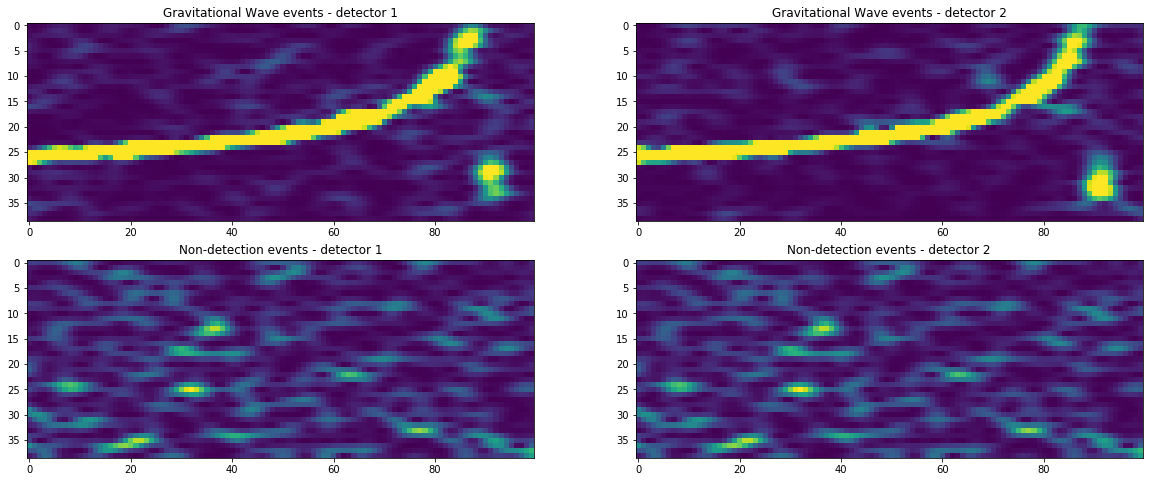

In [6]:
# Visualization
fig, ax = plt.subplots(2, 2, figsize=(20,8))

ax[0][0].imshow(GW[3,:,:,0]/255)
ax[0][0].set_title("Gravitational Wave events - detector 1")

ax[0][1].imshow(GW[3,:,:,1]/255)
ax[0][1].set_title("Gravitational Wave events - detector 2")

ax[1][0].imshow(ND[3,:,:,0]/255)
ax[1][0].set_title("Non-detection events - detector 1")

ax[1][1].imshow(ND[3,:,:,0]/255)
ax[1][1].set_title("Non-detection events - detector 2")

plt.show()

<span class='sub-q'> **3.2 Build a CNN Model for GW detection.**</span>

Build a CNN Model to automatically classify event as a GW or an ND. Use a combination of layers such as Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order). 

Summarize your results in a short report. Explain why you chose the architecture you did, described what worked and what didn't. Also describe how did you proceeded to inspect your network as in Q2.

In [7]:
def gw_model(input_shape, num_classes, n_filter=32):
    model = Sequential()
    model.add(Conv2D(n_filter, (5, 5), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(n_filter, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(n_filter, (5, 5), padding='same', activation='relu'))
    model.add(Conv2D(n_filter, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    
    return model

In [8]:
K.clear_session()
gw_model = gw_model(input_shape=(39,100,2), num_classes=2, n_filter=64)

gw_model.compile(loss='binary_crossentropy',
                 optimizer='sgd',
                 metrics=['accuracy'])

gw_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 100, 64)       3264      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 96, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 48, 64)        102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 44, 64)         102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 22, 64)         0         
__________

In [9]:
model_history_gw = gw_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=.2, verbose=0)
gw_model.save('gw_model.h5')

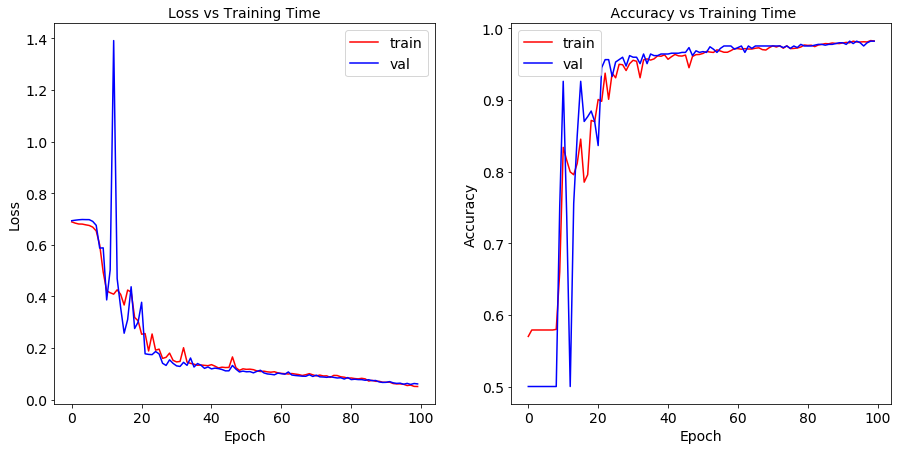

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

ax[0].plot(model_history_gw.history['loss'], 'r', label='train')
ax[0].plot(model_history_gw.history['val_loss'], 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=14)
ax[0].set_ylabel(r'Loss', fontsize=14)
ax[0].set_title(r'Loss vs Training Time', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(model_history_gw.history['acc'], 'r', label='train')
ax[1].plot(model_history_gw.history['val_acc'], 'b' ,label='val')
ax[1].set_xlabel(r'Epoch', fontsize=14)
ax[1].set_ylabel(r'Accuracy', fontsize=14)
ax[1].set_title(r' Accuracy vs Training Time', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(labelsize=14)

In [11]:
print("Training accuracy: %.2f" % model_history_gw.history['acc'][-1])
print("Validation accuracy: %.2f" % model_history_gw.history['val_acc'][-1])
print("Test accuracy: %.2f" % gw_model.evaluate(X_test, y_test, verbose=0)[1])

Training accuracy: 0.98
Validation accuracy: 0.98
Test accuracy: 0.99


Neural Network Architecture:
- A convolutional neural network is built by stacking layers, typically of 3 types: 
    - Convolutional layers: Each convolutional layer learns filters of increasing complexity. The first layers of CNN learn basic feature detection filters: edges, corner, etc. The second CNN layers learn filters that detect parts of objects. The final CNN layers learn full objects.
    - Pooling layers: Maximum pooling layers are typically inserted between convolutional layers to incrase the robustness of feature maps and reduce model complexity.
    - Fully connected layers: Fully connected layers are typically the last layers in the model.
- Other layers: 
    - Dropout layer is a regularization technique to avoid overfitting.
    - Flatten layer is used to covert 2D array to 1D array before the fully connected layer. 
- Optimizor of SGD is fast and can get around local optimum.
- Activation function of ReLU introduces non-linearity to the neural network.
- Activation function of sigmoid in the output layer is because of two classes as reponse variables. 




What worked and what didn't:
- Above model is our well calibrated version, so all components in the model work very well. 
- In the calibration process, we found following points/steps very helpful: 
    - Without the convolutional layers, the model couldn't learn the edges and corners, which gives us a bad predition accuracy.
    - Without the dropout layers, the test accuracy could be very low even validation accuracy might be high.
    - Without lower batch size and lower total number of parameters, we would get ResourceExhaustedError.


Model inspection:
- Visualize the observations with wrong predictions is very helpful to understand why the model is making mistakes. 
- Plot the loss and accuracy as a function of training time is very helpful to avoid overfitting.
- Plot feature maps from an intermediate convolutional layer is helpful for model inspection.
- Saliency maps is a very efficient way to measure the spatial support of a particular class in a given image.

